# Simple CNN architechture

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [2]:
import sys
sys.path.append('../../')
from Evaluation_procedure.eval_functions import isValid, get_depth, calc_errors

In [120]:
import torch
import torchvision
import pandas as pd
import numpy as np
from PIL import Image
from Functions import import_raw_colour_image, import_raw_depth_image, show_depth_image, show_img
import os
from skimage import io, transform
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path
import torch.nn.functional as F
from torchsummary import summary
import math

plt.ion()   # interactive mode

## Reading in the csv data structure

In [4]:
import csv
with open('..\data_descriptions.csv', newline='') as csvfile: ###### data_descriptions csv must be in this relative location
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    count = 0
    for row in spamreader:
        if count == 0:
            folder_names = row
        else:
            num_files = row
        count = 1

In [5]:
for i in range(0,len(num_files)):
    num_files[i] = int(num_files[i])

In [6]:
list_of_numbers = ["{0:05}".format(i) for i in range(1, sum(num_files)+1)]
colour_filenames = []
depth_filenames = []
for num in list_of_numbers:
    colour_filenames.append(f"colour_{num}.raw")
    depth_filenames.append(f"depth_{num}.raw")

## Dataset class

In [7]:
class ModerateDataset(Dataset):

    def __init__(self, col_dir='', depth_dir='', transform=None, trans_on=False):
        self.path_names = {}
        for folder in folder_names:
            self.path_names[f"{folder}"] = {}
        for folder in folder_names:
            self.path_names[f'{folder}']['colour'] = {}
            self.path_names[f'{folder}']['depth'] = {}
        for i in range(1, num_files[0]):
            self.path_names['Sunny']['colour'][f"{i}"] = {}
            self.path_names['Sunny']['depth'][f"{i}"] = {}
        print("*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************")
        count = 0
        for folder in folder_names:
            for i in range(0, num_files[folder_names.index(folder)]):
                self.path_names[f'{folder}']['colour'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/colour/{colour_filenames[count+i]}")  ## Change this path here!!!!
                self.path_names[f'{folder}']['depth'][f'{i+1}'] = Path(f"C:/Users/Ben/OneDrive - Bournemouth University/Computer Vision/Moderate collection/{folder}/depth/{depth_filenames[count+i]}")   ## Change this path here!!!!
            count = count + num_files[folder_names.index(folder)]
        
        self.transform = transform
        self.col_dir = col_dir
        self.depth_dir = depth_dir
        self.trans_on = trans_on

    def __getitem__(self,idx):
        if idx == 0:
            
            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx+1}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx+1}']
        
        if (idx>0 and idx <= num_files[0]):  ## 1-500

            self.col_dir = self.path_names[f'{folder_names[0]}']['colour'][f'{idx}']
            self.depth_dir = self.path_names[f'{folder_names[0]}']['depth'][f'{idx}']

        elif (idx > num_files[0] and idx < (sum(num_files[:2])+1)): ## 501 - 1500

            self.col_dir = self.path_names[f'{folder_names[1]}']['colour'][f'{idx-num_files[0]}']
            self.depth_dir = self.path_names[f'{folder_names[1]}']['depth'][f'{idx-num_files[0]}']

        elif (idx > sum(num_files[:2]) and idx < (sum(num_files[:3])+1) ): ## 1501 - 2600

            self.col_dir = self.path_names[f'{folder_names[2]}']['colour'][f'{idx-sum(num_files[:2])}'] # -1500
            self.depth_dir = self.path_names[f'{folder_names[2]}']['depth'][f'{idx-sum(num_files[:2])}']

        elif (idx > sum(num_files[:3]) and idx < (sum(num_files[:4])+1) ): ## 2601 - 5600

            self.col_dir = self.path_names[f'{folder_names[3]}']['colour'][f'{idx-sum(num_files[:3])}'] #-2600
            self.depth_dir = self.path_names[f'{folder_names[3]}']['depth'][f'{idx-sum(num_files[:3])}']
            
        elif (idx > sum(num_files[:4]) and idx < (sum(num_files[:5])+1) ): ## 5601 - 7857

            self.col_dir = self.path_names[f'{folder_names[4]}']['colour'][f'{idx-sum(num_files[:4])}'] # -5600
            self.depth_dir = self.path_names[f'{folder_names[4]}']['depth'][f'{idx-sum(num_files[:4])}']

        elif (idx > sum(num_files)):
            raise NameError('Index outside of range')

        col_img = import_raw_colour_image(self.col_dir)
        depth_img = import_raw_depth_image(self.depth_dir)
        if self.trans_on == True:
            col_img = torch.from_numpy(np.flip(col_img,axis=0).copy()) # apply any transforms
            depth_img = torch.from_numpy(np.flip(depth_img,axis=0).copy()) # apply any transforms
            col_img = col_img.transpose(0,2)
            col_img = col_img.transpose(1,2)
        if self.transform: # if any transforms were given to initialiser
            col_img = self.transform(col_img) # apply any transforms
        return col_img, depth_img
    
    def __len__(self):
        return sum(num_files)



In [8]:
total_Data = ModerateDataset(trans_on=True)  ## instancing the dataset

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


## Train/test splitting

Dataset is split 80/10/10 train/validation/testing

In [9]:
train_size = int(0.8 * len(total_Data))
val_size = int((len(total_Data) - train_size)/2)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(total_Data, [train_size, val_size, val_size])

In [10]:
batch_sz = 16
tr_dl  = DataLoader(train_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)
val_dl = DataLoader(val_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)
test_dl = DataLoader(test_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)

## Training loop

In [11]:
def fit(net, tr_dl, val_dl, loss=nn.MSELoss(), epochs=3, lr=3e-3, wd=1e-3):   
    # print("hello")
    Ltr_hist, Lval_hist = [], []
    
    opt = optim.Adam(net.parameters(), lr=lr, weight_decay=wd)
    # print("opt")
    for epoch in trange(epochs):
        # print("epoch")
        L = []
        dl = (iter(tr_dl))
        # print("dl")
        count_train = 0
        for xb, yb in tqdm(dl, leave=False):
            # print("xb,yb loop")
            xb, yb = xb.float(), yb.float()
            xb, yb = xb.cuda(), yb.cuda()
            # print("xb,yb cuda")
            y_ = net(xb)
            # print("y_")
            l = loss(y_, yb)
            opt.zero_grad()
            l.backward()
            opt.step()
            L.append(l.detach().cpu().numpy())
            print(f"Training on batch {count_train} of {int(train_size/batch_sz)}")
            count_train+= 1

        # disable gradient calculations for validation     
        for p in net.parameters(): p.requires_grad = False 

        Lval, Aval = [], []
        val_it = iter(val_dl)
        val_count = 0
        for xb, yb in tqdm(val_it, leave=False):
            xb, yb = xb.float(), yb.float()
            xb, yb = xb.cuda(), yb.cuda()
            y_ = net(xb)
            l = loss(y_, yb)
            Lval.append(l.detach().cpu().numpy())
            Aval.append((y_.max(dim=1)[1] == yb).float().mean().cpu().numpy())
            print(f"Validating on batch {val_count} of {int(val_size/batch_sz)}")
            val_count+= 1

        # enable gradient calculations for next epoch 
        for p in net.parameters(): p.requires_grad = True 
            
        Ltr_hist.append(np.mean(L))
        Lval_hist.append(np.mean(Lval))
        print(f'training loss: {np.mean(L):0.4f}\tvalidation loss: {np.mean(Lval):0.4f}\tvalidation accuracy: {np.mean(Aval):0.2f}')
    return Ltr_hist, Lval_hist

# Network

In [12]:
# net = nn.Sequential(
#     nn.Conv2d(in_channels=3,  out_channels=6, kernel_size=3, stride=1, padding=1), 
#     nn.ReLU(),
#     nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.ConvTranspose2d(in_channels = 12, out_channels=6, kernel_size=3, stride=1, padding=1),
#     nn.ReLU(),
#     nn.ConvTranspose2d(in_channels = 6, out_channels=1, kernel_size=3, stride=1, padding=1),
#     nn.ReLU()
# ).cuda()


In [13]:
# summary(net, (3,720,1280), 8)

# Testing the fit function

## Training the network
Takes ~30 mins/epoch

In [14]:
#Ltr_hist, Lval_hist = fit(net.cuda(), tr_dl, val_dl, epochs=2)

# LOADING A SAVED MODEL

In [15]:
path = 'model_20042020'

In [16]:
#torch.save(net, path)

In [17]:
re_load_trained_model = torch.load(path)

In [18]:
re_load_trained_model.eval()

Sequential(
  (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): ConvTranspose2d(12, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): ConvTranspose2d(6, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
)

# Evaluation

In [19]:
torch.cuda.empty_cache() 

In [20]:
count_test_batches = 0
for xb, yb in tqdm(test_dl, leave=False):
    if count_test_batches == 0:
        # initialise list of predicted depths
        numpy_depth_prediction = [None]*int(val_size/batch_sz+1)
        gt_depths = [None]*int(val_size/batch_sz+1)
        for i in range(0, int(val_size/batch_sz+1)):
            numpy_depth_prediction[i] = [None]*xb.shape[0]
            gt_depths[i] = [None]*xb.shape[0]
    # transform data into floats and then place on gpu
    xb, yb = xb.float(), yb.float()
    xb, yb = xb.cuda(), yb.cuda()

    # store ground truth depth on the cpu in numpy form for evaluation
    real_depth = yb.cpu().detach().numpy()


    #print(xb.shape[0], yb.shape, real_depth.shape)

    # run the x's through the trained network to predict their depth maps
    prediction = re_load_trained_model(xb)


    #print(f'output shape is {prediction.shape}')
    #print(prediction[1].cpu().detach().numpy())
    
    # save each predicted depth map in the batch to a list as a numpy array
    for i in range(0, xb.shape[0]):
        # print(i)
        numpy_depth_prediction[count_test_batches][i] = np.reshape(prediction[i].cpu().detach().numpy(), (720,1280))
        gt_depths[count_test_batches][i] = yb[i].cpu().detach().numpy()
    #print(gt_depths)
    count_test_batches += 1
    
    # print(numpy_prediction.shape)
    # show_depth_image(numpy_prediction[0])

## Initialise a dictionary for holding the calculated errors

In [42]:
error_dictionary = {}
for i in range(int(val_size/batch_sz+1)):
        error_dictionary[f"{i}"] = {}
for i in range(int(val_size/batch_sz+1)):
    for j in range(batch_sz):
        error_dictionary[f"{i}"][f"{j}"] = {}
# error_dictionary

In [48]:
%%time
for i in range(int(val_size/batch_sz+1)):
    if i == 49:
        error_dictionary[f"{i}"][f"{0}"] = calc_errors(numpy_depth_prediction[i][0], gt_depths[i][0])
        error_dictionary[f"{i}"][f"{1}"] = calc_errors(numpy_depth_prediction[i][1], gt_depths[i][1])
    else:
        for j in range(batch_sz-1): # batch_sz):
            error_dictionary[f"{i}"][f"{j}"] = calc_errors(numpy_depth_prediction[i][j], gt_depths[i][j])
    print(f"Calculating errors for batch {i} of {int(val_size/batch_sz)}")

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
11
11
11
11
11
11
11
11
11
11
11
11
11
11
11
12
12
12
12
12
12
12
12
12
12
12
12
12
12
12
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
14
14
14
14
14
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
15
15
15
15
15
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
17
17
17
17
17
17
17
17
17
17
17
17
17
17
17
18
18
18
18
18
18
18
18
18
18
18
18
18
18
18
19
19
19
19
19
19
19
19
19
19
19
19
19
19
19
20
20
20
20
20
20
20
20
20
20
20
20
20
20
20
21
21
21
21
21
21
21
21
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
22
22
22
22
22
23
23
23
23
23
23
23
23
23
23
23
23
23
23
23
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
25
25
25
25
25
25
25
25
2

AttributeError: 'NoneType' object has no attribute 'shape'

## Calculate average errors over test dataset

In [124]:
%%time
# initialisation of average errors
difference_err_avg = 0
sqr_diff_err_avg = 0
inv_err_avg = 0
inv_sqr_err_avg = 0
log_err_avg = 0
log_sqr_err_avg = 0
log_non_abs_err_avg = 0
abs_rel_err_avg = 0
sqr_rel_err_avg = 0

Wall time: 0 ns


In [125]:
%%time
for i in range(0, int(val_size/batch_sz)):
    for j in range(0, batch_sz-1):
        difference_err_avg += error_dictionary[f"{i}"][f"{j}"][0]
        sqr_diff_err_avg += error_dictionary[f"{i}"][f"{j}"][1]
        inv_err_avg += error_dictionary[f"{i}"][f"{j}"][2]
        inv_sqr_err_avg += error_dictionary[f"{i}"][f"{j}"][3]
        log_err_avg += error_dictionary[f"{i}"][f"{j}"][4]
        log_sqr_err_avg += error_dictionary[f"{i}"][f"{j}"][5]
        log_non_abs_err_avg += error_dictionary[f"{i}"][f"{j}"][6]
        abs_rel_err_avg += error_dictionary[f"{i}"][f"{j}"][7]
        sqr_rel_err_avg += error_dictionary[f"{i}"][f"{j}"][8]

Wall time: 2.44 ms


In [126]:
## divide by number of images to get average error
difference_err_avg /= (val_size)
sqr_diff_err_avg /= (val_size)
inv_err_avg /= (val_size)
inv_sqr_err_avg /= (val_size)
log_err_avg /= (val_size)
log_sqr_err_avg /= (val_size)
log_non_abs_err_avg /= (val_size)
abs_rel_err_avg /= (val_size)
sqr_rel_err_avg /= (val_size)
print(difference_err_avg, sqr_diff_err_avg, inv_err_avg, inv_sqr_err_avg, log_err_avg, log_sqr_err_avg, log_non_abs_err_avg, abs_rel_err_avg, sqr_rel_err_avg)

0.15349015485873604 0.20413706169302126 216.92079890689172 449.87569844827283 1.4395006203028675 1.6912679620310802 1.0779036028588291 17.408615003311972 57917.195704816244


## Calculate standard deviation in average errors

In [127]:
# initialise difference counters
diff_count = 0 
sqr_diff_count = 0
inv_diff_count = 0
inv_sqr_diff_count = 0
log_err_count = 0
log_sqr_count = 0
log_non_diff_count = 0
abs_rel_count = 0
sqr_rel_count = 0

In [128]:
%%time
# sum squared differences
for i in range(0, int(val_size/batch_sz)):
    for j in range(0, batch_sz-1):
            diff_count += (error_dictionary[f"{i}"][f"{j}"][0] - difference_err_avg)**2
            sqr_diff_count += (error_dictionary[f"{i}"][f"{j}"][0] - sqr_diff_err_avg)**2
            inv_diff_count += (error_dictionary[f"{i}"][f"{j}"][0] - inv_err_avg)**2
            inv_sqr_diff_count += (error_dictionary[f"{i}"][f"{j}"][0] - inv_sqr_err_avg)**2
            log_err_count += (error_dictionary[f"{i}"][f"{j}"][0] - log_err_avg)**2
            log_sqr_count += (error_dictionary[f"{i}"][f"{j}"][0] - log_sqr_err_avg)**2
            log_non_diff_count += (error_dictionary[f"{i}"][f"{j}"][0] - log_non_abs_err_avg)**2
            abs_rel_count += (error_dictionary[f"{i}"][f"{j}"][0] - abs_rel_err_avg)**2
            sqr_rel_count += (error_dictionary[f"{i}"][f"{j}"][0] - sqr_rel_err_avg)**2

Wall time: 6.13 ms


In [129]:
# divide by number of test images
diff_count /= (val_size)
sqr_diff_count /= (val_size)
inv_diff_count /= (val_size)
inv_sqr_diff_count /= (val_size)
log_err_count /= (val_size)
log_sqr_count /= (val_size)
log_non_diff_count /= (val_size)
abs_rel_count /= (val_size)
sqr_rel_count /= (val_size)

In [130]:
# square root
diff_sigma = math.sqrt(diff_count)
sqr_diff_sigma = math.sqrt(sqr_diff_count)
inv_diff_sigma = math.sqrt(inv_diff_count)
inv_sqr_diff_sigma = math.sqrt(inv_sqr_diff_count)
log_err_sigma = math.sqrt(log_err_count)
log_sqr_sigma = math.sqrt(log_sqr_count)
log_non_diff_sigma = math.sqrt(log_non_diff_count)
abs_rel_sigma = math.sqrt(abs_rel_count)
sqr_rel_sigma = math.sqrt(sqr_rel_count)

In [131]:
difference_err_avg , diff_sigma

(0.15349015485873604, 0.08930094275341093)

In [ ]:
xb, yb = next(iter(test_dl))
#for xb, yb in tqdm(next(iter(val_dl)), leave=False):
xb, yb = xb.float(), yb.float()
xb, yb = xb.cuda(), yb.cuda()
output = re_load_trained_model(xb)
print(f'output shape is {output.shape}')
numpy_out_1 = output[0].cpu().detach().numpy()
print(numpy_out_1.shape)
show_depth_image(numpy_out_1[0])

In [ ]:
numpy_out_1[0]

In [25]:
real_depth = yb.cpu().detach().numpy()
real_depth.shape

(2, 720, 1280)

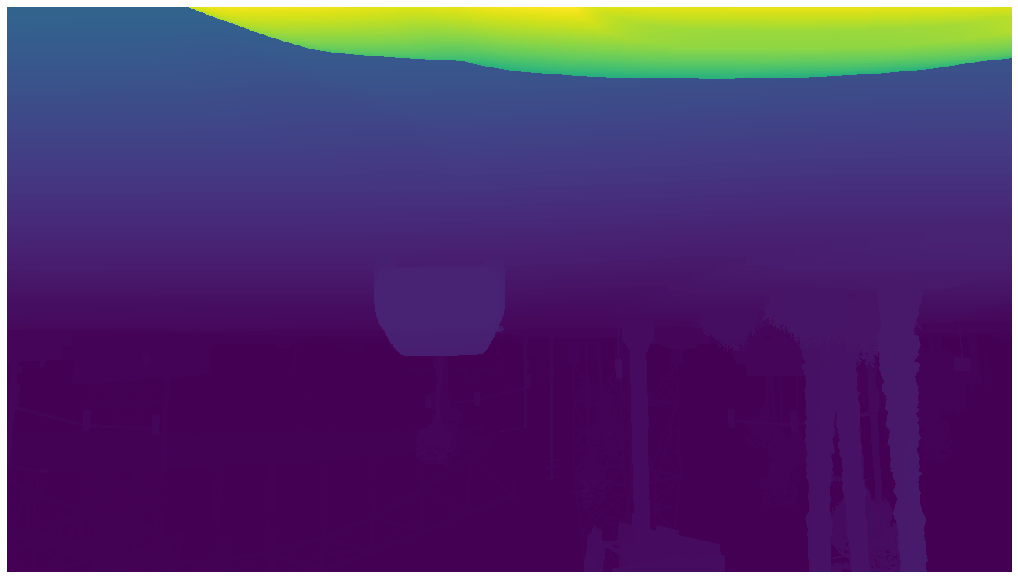

In [24]:
show_depth_image(real_depth[0])

In [52]:
calc_errors(numpy_out_1[0], real_depth[0])

[0.15002256780862808,
 0.24982810310873052,
 108.66197061297287,
 145.36742582933428,
 1.526882595887625,
 1.6617311219681923,
 0.9248991929212328,
 4.5609873831272125,
 32.48820402026176]

In [44]:
real_colour = xb.cpu().detach().numpy()

In [45]:
real_colour_0 = real_colour[0].reshape(int(720),1280 ,- 1)
real_colour_0 = real_colour_0/255

In [46]:
real_colour_0.shape

(720, 1280, 3)

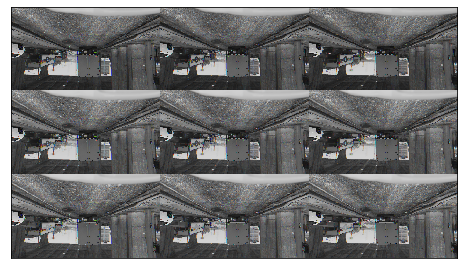

In [47]:
show_img(real_colour_0)

# Standardisation

train dataloader is called tr_dl

In [21]:
mean = 0.0
count_mn = 0
for images, _ in tr_dl:
    images = images.float()
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    print(f"Whirrrrrr calculating..... {count_mn} of {train_size/batch_sz}")
    count_mn+= 1
mean = mean / len(tr_dl.dataset)


Whirrrrrr calculating..... 0 of 392.8125
Whirrrrrr calculating..... 1 of 392.8125
Whirrrrrr calculating..... 2 of 392.8125
Whirrrrrr calculating..... 3 of 392.8125
Whirrrrrr calculating..... 4 of 392.8125
Whirrrrrr calculating..... 5 of 392.8125
Whirrrrrr calculating..... 6 of 392.8125
Whirrrrrr calculating..... 7 of 392.8125
Whirrrrrr calculating..... 8 of 392.8125
Whirrrrrr calculating..... 9 of 392.8125
Whirrrrrr calculating..... 10 of 392.8125
Whirrrrrr calculating..... 11 of 392.8125
Whirrrrrr calculating..... 12 of 392.8125
Whirrrrrr calculating..... 13 of 392.8125
Whirrrrrr calculating..... 14 of 392.8125
Whirrrrrr calculating..... 15 of 392.8125
Whirrrrrr calculating..... 16 of 392.8125
Whirrrrrr calculating..... 17 of 392.8125
Whirrrrrr calculating..... 18 of 392.8125
Whirrrrrr calculating..... 19 of 392.8125
Whirrrrrr calculating..... 20 of 392.8125
Whirrrrrr calculating..... 21 of 392.8125
Whirrrrrr calculating..... 22 of 392.8125
Whirrrrrr calculating..... 23 of 392.8125
Wh

NameError: name 'count_var' is not defined

In [22]:
mean

tensor([ 98.2207, 101.6702, 102.9898])

In [24]:

var = 0.0
count_var =0
for images, _ in tr_dl:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
    print(f"Whirrrrrr calculating..... {count_var} of {train_size/batch_sz}")
    count_var+= 1
std = torch.sqrt(var / (len(tr_dl.dataset)*720*1280))

Whirrrrrr calculating..... 0 of 392.8125
Whirrrrrr calculating..... 1 of 392.8125
Whirrrrrr calculating..... 2 of 392.8125
Whirrrrrr calculating..... 3 of 392.8125
Whirrrrrr calculating..... 4 of 392.8125
Whirrrrrr calculating..... 5 of 392.8125
Whirrrrrr calculating..... 6 of 392.8125
Whirrrrrr calculating..... 7 of 392.8125
Whirrrrrr calculating..... 8 of 392.8125
Whirrrrrr calculating..... 9 of 392.8125
Whirrrrrr calculating..... 10 of 392.8125
Whirrrrrr calculating..... 11 of 392.8125
Whirrrrrr calculating..... 12 of 392.8125
Whirrrrrr calculating..... 13 of 392.8125
Whirrrrrr calculating..... 14 of 392.8125
Whirrrrrr calculating..... 15 of 392.8125
Whirrrrrr calculating..... 16 of 392.8125
Whirrrrrr calculating..... 17 of 392.8125
Whirrrrrr calculating..... 18 of 392.8125
Whirrrrrr calculating..... 19 of 392.8125
Whirrrrrr calculating..... 20 of 392.8125
Whirrrrrr calculating..... 21 of 392.8125
Whirrrrrr calculating..... 22 of 392.8125
Whirrrrrr calculating..... 23 of 392.8125
Wh

In [25]:
std

tensor([63.4003, 64.1523, 64.4491])

In [29]:
Moderate_tr_stats = mean, std

mean is tensor([ 98.2207, 101.6702, 102.9898])
std is tensor([63.4003, 64.1523, 64.4491])

In [30]:
transforms.Normalize(*Moderate_tr_stats)

Normalize(mean=tensor([ 98.2207, 101.6702, 102.9898]), std=tensor([63.4003, 64.1523, 64.4491]))

In [45]:
normed_dataset = ModerateDataset(trans_on=True, transform=transforms.Normalize(*Moderate_tr_stats))

*************MAKE SURE THE PATH FILE IN THE FOR LOOP IS THE BASE IMAGE DIRECTORY ON YOUR COMPUTER**************


In [46]:
normed_dl = DataLoader(normed_dataset,  batch_size=batch_sz, shuffle=True,  num_workers=0)

In [48]:
next(iter(normed_dl))

[tensor([[[[2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           ...,
           [3, 3, 3,  ..., 3, 3, 3],
           [3, 3, 3,  ..., 3, 3, 3],
           [3, 3, 3,  ..., 3, 3, 3]],
 
          [[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3]],
 
          [[2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           [2, 2, 2,  ..., 2, 2, 2],
           ...,
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3],
           [2, 2, 2,  ..., 3, 3, 3]]],
 
 
         [[[3, 3, 3,  ..., 0, 0, 0],
           [3, 3, 3,  ..., 0, 0, 0],
           [3, 3, 3,  ..., 0, 0, 0],
           ...,
           [2, 2, 2,  ..., 1, 1, 1],
           [2, 2, 2,  ..., 1, 1, 1],
           [2, 2, 2,  ..., 1, 1, 1]],
 
          [[3, 3, 3,  ..., 0, 0, 